In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(cv2.__version__)
print(tf.__version__)

/home/vclab/anaconda3/envs/henrik/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1
1.8.0


# Load images

In [2]:
from os import listdir
from os.path import isfile, join
img_files = [f for f in listdir('images3') if isfile(join('images3', f))]
no_frames = len(img_files)
images = []
for frame in range(0,no_frames):
    filename = 'images3/frame' + str(frame+1) + '.png'
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32) / 255.
    images.append(img)

# Reference image

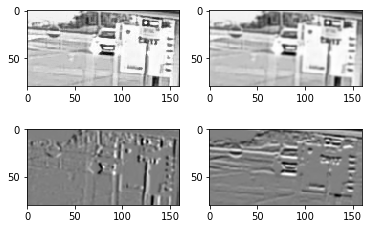

In [3]:
im1 = images[0]
im1_filt = cv2.GaussianBlur(im1,(3,3),0)
Ix = np.gradient(im1_filt, axis=1)
Iy = np.gradient(im1_filt, axis=0)
plt.figure()
plt.subplot(221)
plt.imshow(im1, cmap='gray')
plt.subplot(222)
plt.imshow(im1_filt, cmap='gray')
plt.subplot(223)
plt.imshow(Ix, cmap='gray')
plt.subplot(224)
plt.imshow(Iy, cmap='gray')

# Binary mask

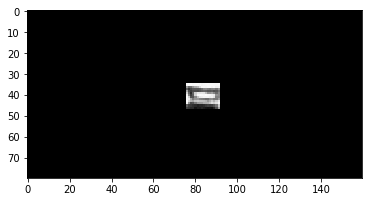

In [4]:
#xmin = 24
#ymin = 14
#width = 16
#height = 12
xmin = 76
ymin = 35
width = 16
height = 12

mask = np.zeros(im1.shape, dtype=np.float32)
mask[ymin:ymin+height,xmin:xmin+width] = 1.

mask_flat = mask.flatten()
sel_ix = np.where(mask_flat > 0)
num_pix = sel_ix[0].shape[0]
#mask_flat_reshape = mask_flat.reshape(mask.shape)

plt.figure()
plt.imshow(np.multiply(im1,mask), cmap='gray')

# Grid

In [5]:
N = mask.shape[0]
M = mask.shape[1]
x = np.arange(M)
y = np.arange(N)
X, Y = np.meshgrid(x, y)
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [6]:
Ix_flat = Ix.flatten()
Iy_flat = Iy.flatten()
X_flat = X.flatten()
Y_flat = Y.flatten()
A = np.zeros((num_pix,6), dtype=np.float32)
b = np.zeros((num_pix,1), dtype=np.float32)
A[:,0] = Ix_flat[sel_ix]
A[:,1] = np.multiply(Ix_flat[sel_ix],X_flat[sel_ix])
A[:,2] = np.multiply(Ix_flat[sel_ix],Y_flat[sel_ix])
A[:,3] = Iy_flat[sel_ix]
A[:,4] = np.multiply(Iy_flat[sel_ix],X_flat[sel_ix])
A[:,5] = np.multiply(Iy_flat[sel_ix],Y_flat[sel_ix])

# Optical flow

In [7]:
no_frames = len(images);
res = []
orig = []
flowX = []
flowY = []
res.append(images[0])
orig.append(images[0])
U0 = np.zeros(mask.shape, dtype=np.float32)
V0 = np.zeros(mask.shape, dtype=np.float32)
flowX.append(U0)
flowY.append(V0)
for frame in range(1, no_frames):
    im2 = images[frame]

    # apply accumulated warp
    X2 = X + U0;
    Y2 = Y + V0;
    im2_warped = cv2.remap(im2, X2, Y2, cv2.INTER_LINEAR)
    
    # filter image and calculate It
    im2_filt = cv2.GaussianBlur(im2_warped,(3,3),0)
    It = im2_filt-im1_filt;
    It_flat = It.flatten()
    
    # Calculate OF
    b = -It_flat[sel_ix]
    a = np.dot(np.dot(np.linalg.pinv(np.dot(A.transpose(),A)),A.transpose()),b)
    
    #U = np.zeros(mask.shape, dtype=np.float32)
    #V = np.zeros(mask.shape, dtype=np.float32)
    U = a[0] + a[1]*X + a[2]*Y;
    V = a[3] + a[4]*X + a[5]*Y;
    
    # Warp im1 to fit with im2
    X2 = X + U0 + U
    Y2 = Y + V0 + V
    im2_warped = cv2.remap(im2, X2, Y2, cv2.INTER_LINEAR)
    
    res.append(im2_warped)
    orig.append(im2)
    
    U0 = U0 + U
    V0 = V0 + V
    
    flowX.append(U0)
    flowY.append(V0)

# Test optical flow

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/vclab/anaconda3/envs/henrik/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


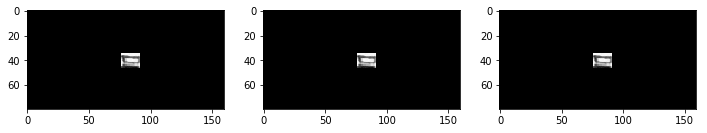

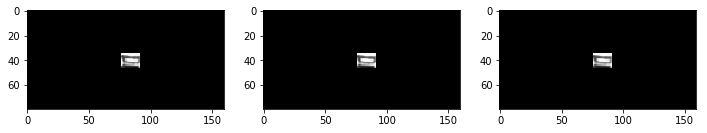

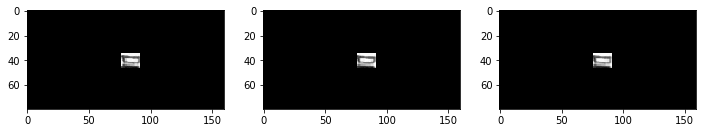

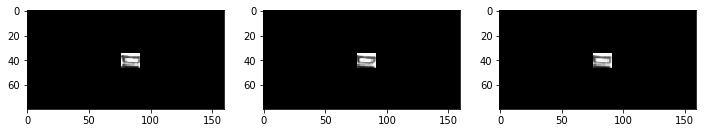

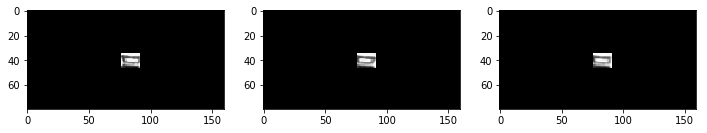

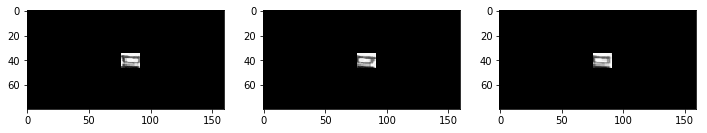

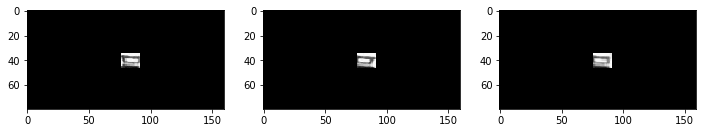

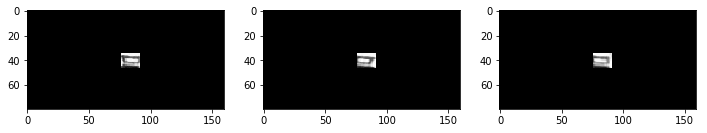

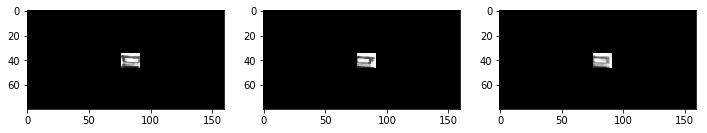

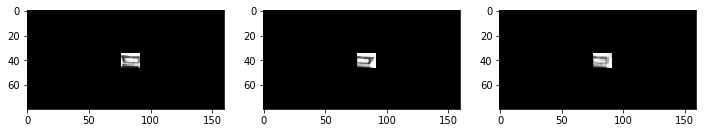

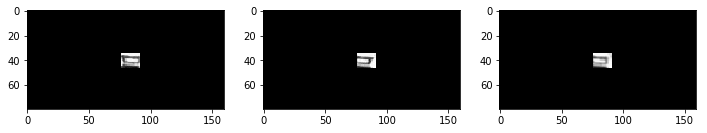

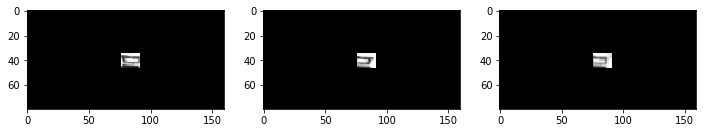

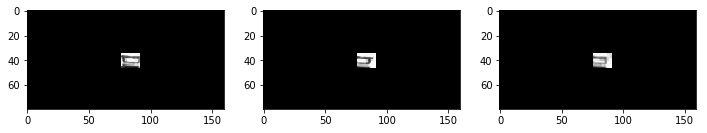

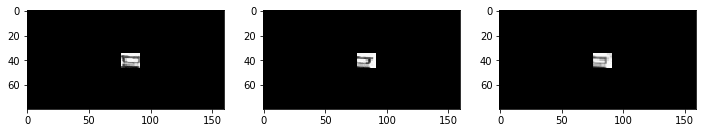

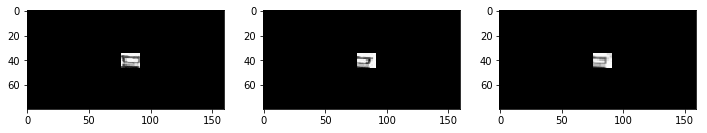

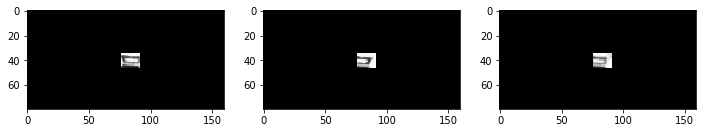

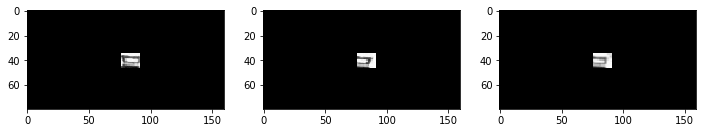

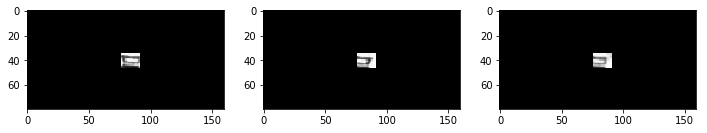

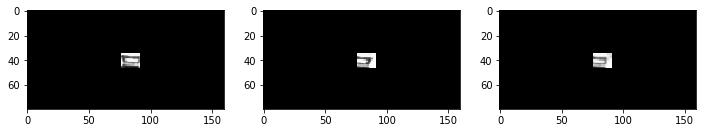

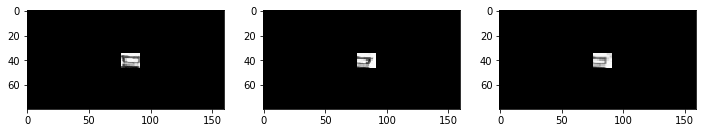

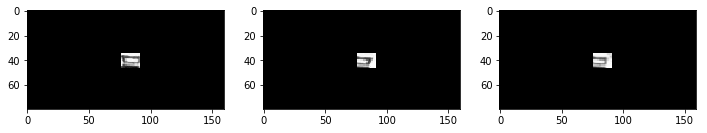

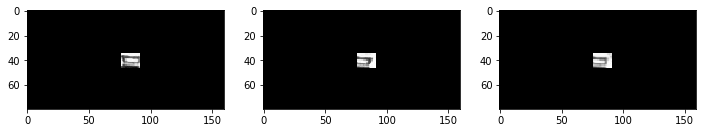

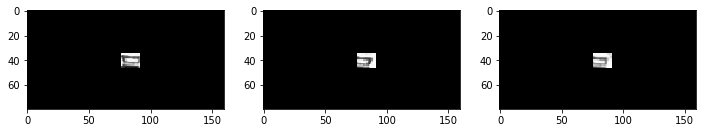

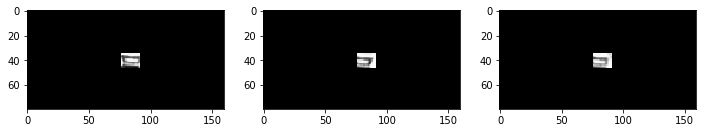

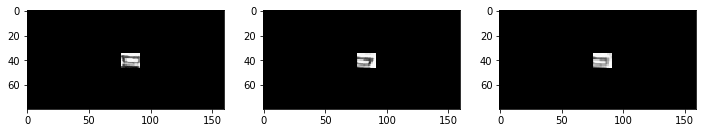

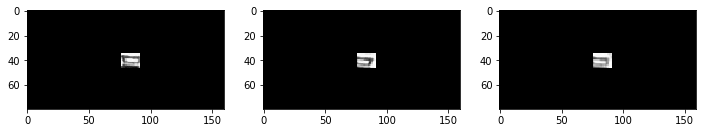

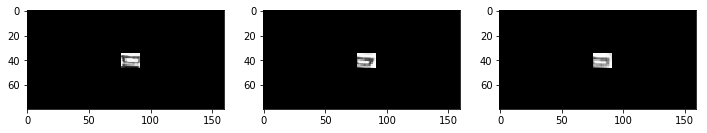

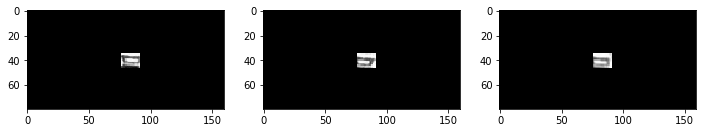

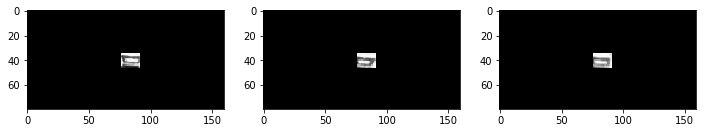

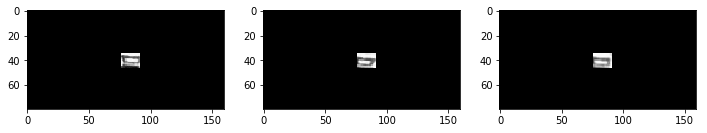

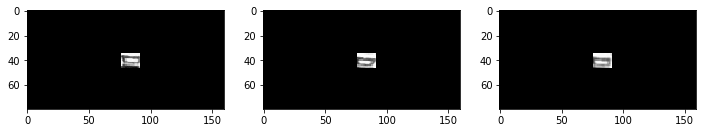

In [9]:
def warp():
    img_highres = tf.placeholder(tf.float32,shape=((1,N,M,1)),name='img')
    flow = tf.placeholder(tf.float32,shape=((1,N,M,2)),name='flow')
    img_warped = tf.contrib.image.dense_image_warp(img_highres,flow)
    return {
        'img_highres': img_highres,
        'flow': flow,
        'img_warped': img_warped
    }

was = warp()

# Reshape high res image
img_highres_np = np.reshape(images[0],(1,N,M,1)).astype(np.float32)

for frame in range(0, no_frames):
    flow_np = np.zeros((1,N,M,2), dtype=np.float32)
    flow_np[0,:,:,0] = flowY[frame]
    flow_np[0,:,:,1] = flowX[frame]
    feed_dict = {
        was['img_highres']: img_highres_np,
        was['flow']: flow_np
    }
    img_warped_out = sess.run(was['img_warped'], feed_dict=feed_dict)
    img_warped_out = img_warped_out.squeeze()
    
    plt.figure(figsize=(12, 12))
    plt.subplot(131)
    plt.imshow(np.multiply(mask,images[0]), cmap='gray')
    plt.subplot(132)
    plt.imshow(np.multiply(mask,images[frame]), cmap='gray')
    plt.subplot(133)
    plt.imshow(np.multiply(mask,img_warped_out), cmap='gray')

# Set up cost function and initialize tensors

In [10]:
scale = 4.
N = int(N*scale)
M = int(M*scale)

In [16]:
# Optimization
learning_rate = 0.01
global_step_encoder = tf.Variable(0, trainable=False)
starter_learning_rate = learning_rate
learning_rate_encoder = tf.train.exponential_decay(starter_learning_rate, global_step_encoder, 100, 0.96, staircase=True)
tv_weight = 0.1

# Cost function - essentially the same as function warp_and_downscale()
img_highres = tf.Variable(np.random.uniform(size=(1,N,M,1)), name = "img_highres")
img_highres_tile = tf.tile(img_highres,[no_frames,1,1,1])
ref = tf.placeholder(tf.float32,shape=((no_frames,int(N/scale),int(M/scale),1)),name='img')
flow = tf.placeholder(tf.float32,shape=((no_frames,int(N/scale),int(M/scale),2)),name='flow')
flow_scale = tf.image.resize_bilinear(scale*flow,[N,M])
img_warped = tf.contrib.image.dense_image_warp(img_highres_tile,flow_scale)
img_warped = tf.image.resize_bilinear(img_warped,[int(N/scale),int(M/scale)])
#cost = tf.losses.mean_squared_error(img_warped,ref)
mse = tf.losses.mean_squared_error(img_warped,ref)
tv = tf.image.total_variation(img_highres) / N / M
cost = mse + tv_weight * tf.cast(tv, tf.float32)

# Optimizer
optimizer_encoder = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op_encoder = optimizer_encoder.minimize(loss=cost,global_step=global_step_encoder)

# Initialize
sess.run(tf.global_variables_initializer())
ref_np = np.zeros((no_frames,int(N/scale),int(M/scale),1), dtype=np.float32)
flow_np = np.zeros((no_frames,int(N/scale),int(M/scale),2), dtype=np.float32)
for frame in range(0, no_frames):
    ref_np[frame,:,:,0] = images[frame]
    flow_np[frame,:,:,0] = flowY[frame]
    flow_np[frame,:,:,1] = flowX[frame]
    
feed_dict = {
        ref: ref_np,
        flow: flow_np
}

# Test loss
loss_val = sess.run(cost, feed_dict=feed_dict)

# Train model

Global step 1, 0.010000, loss=2.129591e-01


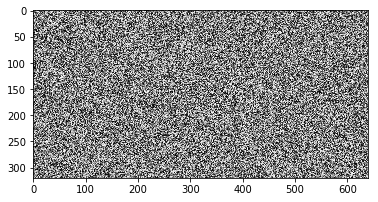

Global step 101, 0.009600, loss=9.887631e-03


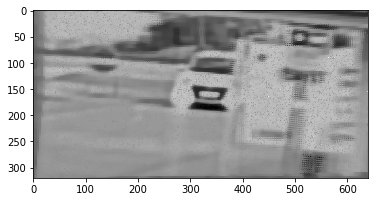

Global step 201, 0.009216, loss=8.064953e-03


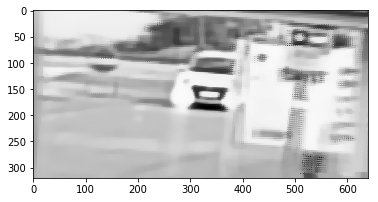

Global step 301, 0.008847, loss=8.042159e-03


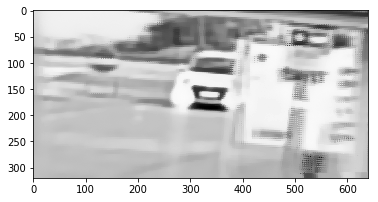

Global step 401, 0.008493, loss=8.040866e-03


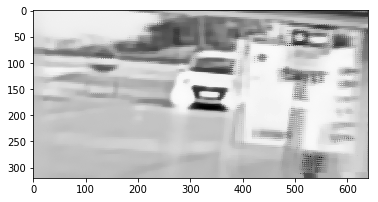

Global step 501, 0.008154, loss=8.042841e-03


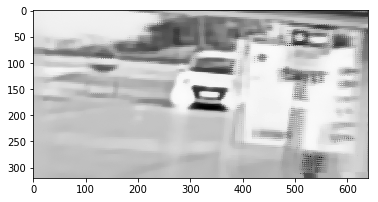

KeyboardInterrupt: 

In [17]:
for iter in range(1000):
    lr,_,loss_val = sess.run([learning_rate_encoder,train_op_encoder,cost], feed_dict=feed_dict)
    gs = tf.train.global_step(sess, global_step_encoder)
    if iter%100 == 0:
        out = sess.run(img_highres)
        out = out.squeeze()
        plt.figure()
        plt.imshow(out, cmap='gray')
        print("Global step %i, %f, %s=%e" % (gs, lr, 'loss',loss_val))
        plt.show()

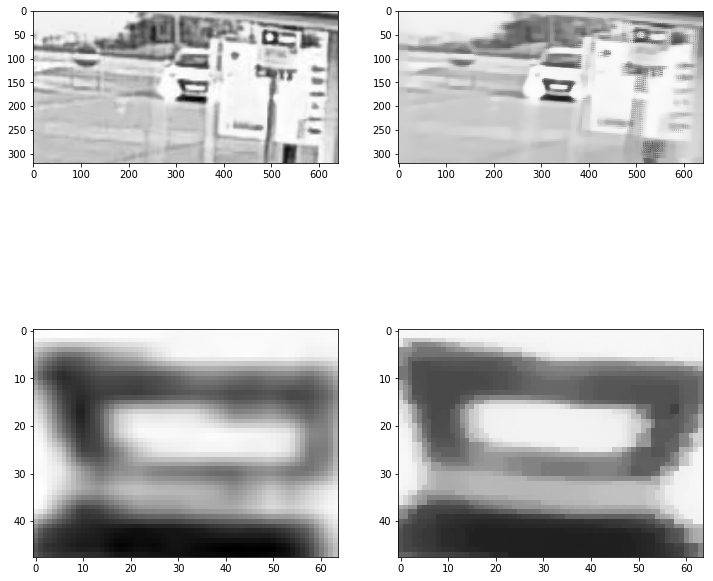

In [27]:
im1_upscale = cv2.resize(im1,(M,N))
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(im1_upscale,cmap='gray')
plt.subplot(222)
plt.imshow(out,cmap='gray',vmin=0,vmax=1)
plt.subplot(223)
plt.imshow(im1_upscale[int(scale*ymin):int(scale*(ymin+height)),int(scale*xmin):int(scale*(xmin+width))],cmap='gray')
plt.subplot(224)
plt.imshow(out[int(scale*ymin):int(scale*(ymin+height)),int(scale*xmin):int(scale*(xmin+width))],cmap='gray',vmin=0,vmax=1)